In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer 
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krrah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(r'data\amazon_alexa.tsv', delimiter = '\t', quoting=3)
print(f"Data shape : {data.shape}")

Data shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback


In [5]:
data['length'] = data['verified_reviews'].apply(len)

In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [7]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [8]:
## Analysing the rating column

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


<Axes: >

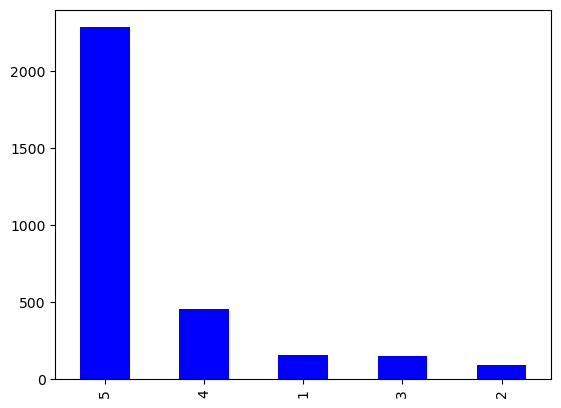

In [9]:
data['rating'].value_counts().plot.bar(color = 'blue')


In [10]:
print(f"Rating value count - percentage distribution : \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution : 
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


<Figure size 700x700 with 0 Axes>

In [12]:
### Preprocessing and modeling


In [13]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]',' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review  if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)
    

In [14]:
cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [15]:
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [16]:
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}" )

X shape : (3150, 2500)
y shape : (3150,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.3, random_state=21)

print(f"X_train : {X_train.shape}")
print(f"y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_test : {y_test.shape}")

X_train : (2205, 2500)
y_train : (2205,)
X_test : (945, 2500)
y_test : (945,)


In [18]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 10
X test max value: 12


In [19]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

In [20]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# Random forest

In [21]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [22]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("testing Accuracy : ", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9954648526077098
testing Accuracy :  0.9312169312169312


In [23]:
y_pred = model_rf.predict(X_test_scl)

In [24]:
cm = confusion_matrix(y_test, y_pred)

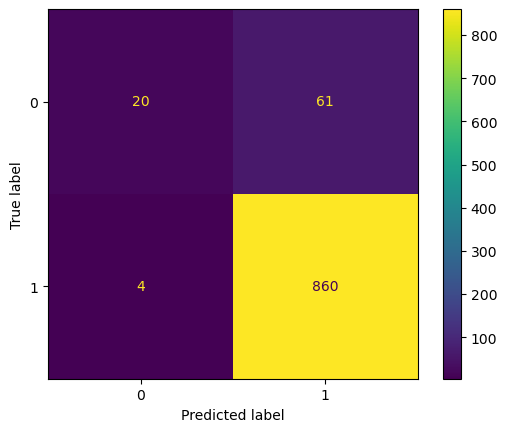

In [25]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [44]:
pickle.dump(model_rf, open("Models/model_rf.pkl", 'wb'))

## K fold cross validation

In [26]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print('accuracy : ', accuracies.mean())
print("Standard variance :", accuracies.std())

accuracy :  0.9424002468120115
Standard variance : 0.003597910628071386


### Apply grid search


In [27]:
params = {
    'bootstrap' : [True],
    'max_depth' : [80,100],
    'min_samples_split' : [8,12],
    'n_estimators' : [100, 300]
}

In [28]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

#### Getting best parameter for Grid Search

In [29]:
print("Best combination : {}".format(grid_search.best_params_)  )


Best combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [30]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))

Cross validation mean accuracy on train set : 96.79707463393845
Cross validation mean accuracy on test set : 92.51700012175999


In [31]:
print('Accuracy score for test set: ', accuracy_score(y_test, y_pred))

Accuracy score for test set:  0.9312169312169312


### XGboost


In [32]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
print("Training Accuracy: ", model_xgb.score(X_train_scl, y_train))
print("Testing  Accuracy: ", model_xgb.score(X_test_scl, y_test))

Training Accuracy:  0.9741496598639455
Testing  Accuracy:  0.9301587301587302


In [34]:
y_pred = model_xgb.predict(X_test)

In [35]:

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 31  50]
 [ 19 845]]


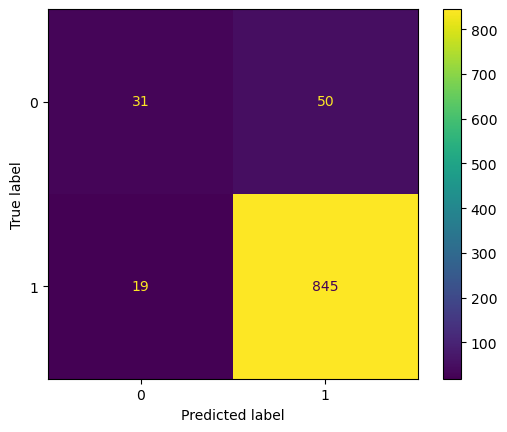

In [36]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [37]:
pickle.dump(model_xgb, open("Models/model_xgb.pkl", 'wb'))

### Decision Tree

In [38]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
print("Training Accuracy: ", model_dt.score(X_train_scl, y_train))
print("Testing  Accuracy: ", model_dt.score(X_test_scl, y_test))

Training Accuracy:  0.9383219954648526
Testing  Accuracy:  0.9058201058201059


In [40]:
y_pred = model_dt.predict(X_test)

In [41]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 35  46]
 [ 30 834]]


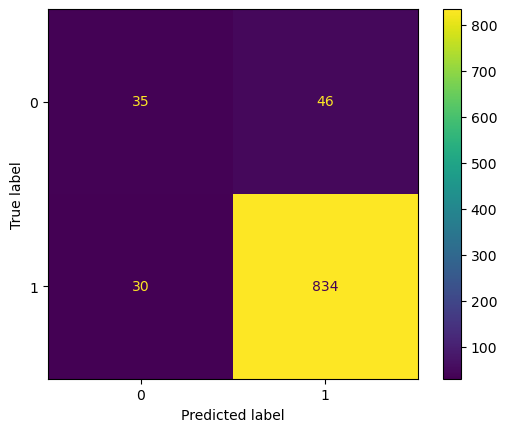

In [42]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [43]:
pickle.dump(model_dt, open("Models/model_dt.pkl", 'wb'))